# Import Libraries

In [1]:
# Common imports
import os
import numpy as np

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# TensorFlow imports
# may differs from version to versions

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.preprocessing import image

## Set Some Parameters

In [10]:
# Dataset information

# Test dataset is set explicitly, because the amount of data is very small
train_image_folder = os.path.join('datasets', 'face_dataset_train_images')
test_image_folder = os.path.join('datasets', 'face_dataset_test_images')
img_height, img_width = 250, 250  # size of images
num_classes = 2  # me - not_me

# Training settings
validation_ratio = 0.10 # 10% for the validation
batch_size = 16

AUTOTUNE = tf.data.AUTOTUNE

## Create Dataset

### Read datasets from folders

In [11]:
# Train and validation sets
train_ds = keras.preprocessing.image_dataset_from_directory(
    train_image_folder,
    validation_split=validation_ratio,
    subset="training",
    seed=42,
    image_size=(img_height, img_width),
    label_mode='categorical',
    batch_size=batch_size,
    shuffle=True)

val_ds = keras.preprocessing.image_dataset_from_directory(
    train_image_folder,
    validation_split=validation_ratio,
    subset="validation",
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=True)

Found 200 files belonging to 2 classes.
Using 180 files for training.
Found 200 files belonging to 2 classes.
Using 20 files for validation.


In [12]:
# Test set
test_ds = keras.preprocessing.image_dataset_from_directory(
    test_image_folder,
    image_size=(img_height, img_width),
    label_mode='categorical',
    shuffle=False)

Found 20 files belonging to 2 classes.


In [13]:
class_names = test_ds.class_names
class_names

['me', 'not_me']

# Build The Model (ResNet50)

In [14]:
base_model = keras.applications.ResNet50(weights='imagenet',
                                         include_top=False,  # without dense part of the network
                                         input_shape=(img_height, img_width, 3))

94781440/94765736 [==============================] - 29s 0us/step


In [15]:
# Set layers to non-trainable
for layer in base_model.layers:
    layer.trainable = False

In [18]:
# Add custom layers on top of ResNet
global_avg_pooling = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(num_classes, activation='sigmoid')(global_avg_pooling)

face_classifier = keras.models.Model(inputs=base_model.input,
                                     outputs=output,
                                     name='ResNet50')
face_classifier.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 250, 250, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 125, 125, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 125, 125, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [19]:
# ModelCheckpoint to save model in case of interrupting the learning process
checkpoint = ModelCheckpoint("models/face_classifier.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only=True,
                             verbose=1)

# EarlyStopping to find best model with a large number of epochs
earlystop = EarlyStopping(monitor='val_loss',
                          restore_best_weights=True,
                          patience=3,  # number of epochs with no improvement after which training will be stopped
                          verbose=1)

callbacks = [earlystop, checkpoint]

In [20]:
face_classifier.compile(loss='categorical_crossentropy',
                        optimizer=keras.optimizers.Adam(learning_rate=0.01),
                        metrics=['accuracy'])

# Training

In [21]:
epochs = 50

In [22]:
history = face_classifier.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds)

face_classifier.save("models/face_classifier.h5")

Epoch 1/50
12/12 [==============================] - 46s 3s/step - loss: 1.8632 - accuracy: 0.7278 - val_loss: 9.2387e-07 - val_accuracy: 1.0000

Epoch 00001: val_loss improved from inf to 0.00000, saving model to models\face_classifier.h5


C:\Users\hello\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/50
12/12 [==============================] - 38s 3s/step - loss: 1.1259e-08 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000

Epoch 00002: val_loss improved from 0.00000 to 0.00000, saving model to models\face_classifier.h5
Epoch 3/50
12/12 [==============================] - 37s 3s/step - loss: 6.6227e-10 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/50
 5/12 [===========>..................] - ETA: 21s - loss: 1.4901e-09 - accuracy: 1.0000

KeyboardInterrupt: 

# Testing

In [23]:
def test_image_classifier_with_folder(model, path, y_true, img_height=250, img_width=250, class_names=['me', 'not_me']):
    '''
    Read all images from 'path' using tensorflow.keras.preprocessing.image module, 
    than classifies them using 'model' and compare result with 'y_true'.
    Calculate total accuracy based on 'path' test set.

    Parameters:
        model : Image classifier
        path (str): Path to the folder with images you want to test classifier on 
        y_true : True label of the images in the folder. Must be in 'class_names' list
        img_height (int): The height of the image that the classifier can process 
        img_width (int): The width of the image that the classifier can process
        class_names (array-like): List of class names 

    Returns:
        None
    '''
    num_classes = len(class_names)  # Number of classes
    total = 0  # number of images total
    correct = 0  # number of images classified correctly

    for filename in os.listdir(path):
        # read each image in the folder and classifies it
        test_path = os.path.join(path, filename)
        test_image = image.load_img(
            test_path, target_size=(img_height, img_width, 3))
        # from image to array, can try type(test_image)
        test_image = image.img_to_array(test_image)
        # shape from (250, 250, 3) to (1, 250, 250, 3)
        test_image = np.expand_dims(test_image, axis=0)
        result = model.predict(test_image)

        y_pred = class_names[np.array(result[0]).argmax(
            axis=0)]  # predicted class
        iscorrect = 'correct' if y_pred == y_true else 'incorrect'
        print('{} - {}'.format(iscorrect, filename))
        for index in range(num_classes):
            print("\t{:6} with probabily of {:.2f}%".format(
                class_names[index], result[0][index] * 100))

        total += 1
        if y_pred == y_true:
            correct += 1

    print("\nTotal accuracy is {:.2f}% = {}/{} samples classified correctly".format(
        correct/total*100, correct, total))

In [24]:
model_name = 'face_classifier.h5'
face_classifier = keras.models.load_model(f'models/{model_name}')

In [25]:
test_image_classifier_with_folder(face_classifier,
                                  'datasets/face_dataset_test_images/me',
                                  y_true='me')

correct - Tedy.1.jpg
	me     with probabily of 99.99%
	not_me with probabily of 0.05%
correct - Tedy.10.jpg
	me     with probabily of 99.99%
	not_me with probabily of 0.07%
correct - Tedy.2.jpg
	me     with probabily of 99.99%
	not_me with probabily of 0.04%
correct - Tedy.3.jpg
	me     with probabily of 99.98%
	not_me with probabily of 0.11%
correct - Tedy.4.jpg
	me     with probabily of 99.98%
	not_me with probabily of 0.07%
correct - Tedy.5.jpg
	me     with probabily of 99.98%
	not_me with probabily of 0.09%
correct - Tedy.6.jpg
	me     with probabily of 99.99%
	not_me with probabily of 0.05%
correct - Tedy.7.jpg
	me     with probabily of 99.99%
	not_me with probabily of 0.06%
correct - Tedy.8.jpg
	me     with probabily of 99.99%
	not_me with probabily of 0.04%
correct - Tedy.9.jpg
	me     with probabily of 99.99%
	not_me with probabily of 0.05%

Total accuracy is 100.00% = 10/10 samples classified correctly


In [26]:
test_image_classifier_with_folder(face_classifier,
                                  'datasets/face_dataset_test_images/not_me',
                                  y_true='not_me')

incorrect - Hakam.1.jpg
	me     with probabily of 99.98%
	not_me with probabily of 0.16%
incorrect - Hakam.10.jpg
	me     with probabily of 99.99%
	not_me with probabily of 0.12%
incorrect - Hakam.2.jpg
	me     with probabily of 99.99%
	not_me with probabily of 0.05%
incorrect - Hakam.3.jpg
	me     with probabily of 99.99%
	not_me with probabily of 0.09%
incorrect - Hakam.4.jpg
	me     with probabily of 99.96%
	not_me with probabily of 0.20%
incorrect - Hakam.5.jpg
	me     with probabily of 99.99%
	not_me with probabily of 0.05%
incorrect - Hakam.6.jpg
	me     with probabily of 99.99%
	not_me with probabily of 0.05%
incorrect - Hakam.7.jpg
	me     with probabily of 100.00%
	not_me with probabily of 0.04%
incorrect - Hakam.8.jpg
	me     with probabily of 99.99%
	not_me with probabily of 0.06%
incorrect - Hakam.9.jpg
	me     with probabily of 99.99%
	not_me with probabily of 0.08%

Total accuracy is 0.00% = 0/10 samples classified correctly


## Test of particular image

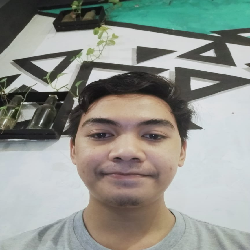

In [28]:
test_path = 'C:/Users/hello/Downloads/WhatsApp Image 2021-12-28 at 18.51.30.jpeg'
test_image = image.load_img(test_path, target_size=(img_height, img_width, 3))
test_image

In [29]:
test_image = image.img_to_array(test_image)  # from image to array
# shape from (250, 250, 3) to (1, 250, 250, 3)
test_image = np.expand_dims(test_image, axis=0)
result = face_classifier.predict(test_image)

for index in range(num_classes):
    print("{:6} with probabily of {:.2f}%".format(
        class_names[index], result[0][index] * 100))

me     with probabily of 29.06%
not_me with probabily of 85.53%


In [31]:
import cv2 # OpenCV

# opencv object that will detect faces for us
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades 
                                    + 'haarcascade_frontalface_default.xml')
video_capture = cv2.VideoCapture(1)  # webcamera

if not video_capture.isOpened():
    print("Unable to access the camera")
else:
    print("Access to the camera was successfully obtained")

print("Streaming started")
while True:
    # Capture frame-by-frame
    ret, frame = video_capture.read()
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    faces = face_cascade.detectMultiScale(
        gray,
        scaleFactor=1.3,
        minNeighbors=5,
        minSize=(100, 100),
        flags=cv2.CASCADE_SCALE_IMAGE
    )

    for (x, y, w, h) in faces:
        # for each face on the image detected by OpenCV
        # draw a rectangle around the face
        cv2.rectangle(frame, 
                    (x, y), # start_point
                    (x+w, y+h), # end_point
                    (255, 0, 0),  # color in BGR
                    2) # thickness in px
        
    # Display the resulting frame
    cv2.imshow("Face detector - to quit press ESC", frame)

    # Exit with ESC
    key = cv2.waitKey(1)
    if key % 256 == 27: # ESC code
        break
        
# When everything done, release the capture
video_capture.release()
cv2.destroyAllWindows()
print("Streaming ended")

Access to the camera was successfully obtained
Streaming started
Streaming ended
